# Lab 12: Modeling

This lab is meant to be short so you can experiment with multiple models, feature engineering methods, etc.

## #1

Build a model using the flights data to predict departure delay. Remember to split your data, examine your data, select features, choose some models to try, train the models, and choose one (possibly based on scoring the models).
- Be careful to avoid leakage! Make sure all of your features make sense as predictors.
- Think: do you need a classification or regression model?
    - Some regression models: Linear Regression, Lasso Regression, Decision Tree Regressor, Random Forest Regressor
    - Some classification models: Gaussian Naive Bayes, Decision Tree Classifier, Random Forest Classifier
- You will find that our features include some categorical variables. We did not spend much time on how to deal with categorical (non-numeric) variables in class. You may either A) drop these features or B) if you're feeling ambitious, look into a technique like one-hot encoding. Look at `sklearn.preprocessing.OneHotEncoder`, or the simpler `pd.get_dummies`.

Note that you may not be able to build a very predictive model without substantial feature engineering.
Consider why this might be so.
Would supplemental data improve your model?

We begin by importing our data.

In [1]:
import pandas as pd

flights = pd.read_csv('../data/flights.csv')
flights.head()

,year,month,day,dep_time,sched_dep_time,dep_delay,arr_time,sched_arr_time,arr_delay,carrier,flight,tailnum,origin,dest,air_time,distance,hour,minute,time_hour
0,2013,1,1,517.0,515,2.0,830.0,819,11.0,UA,1545,N14228,EWR,IAH,227.0,1400,5,15,2013-01-01 05:00:00
1,2013,1,1,533.0,529,4.0,850.0,830,20.0,UA,1714,N24211,LGA,IAH,227.0,1416,5,29,2013-01-01 05:00:00
2,2013,1,1,542.0,540,2.0,923.0,850,33.0,AA,1141,N619AA,JFK,MIA,160.0,1089,5,40,2013-01-01 05:00:00
3,2013,1,1,544.0,545,-1.0,1004.0,1022,-18.0,B6,725,N804JB,JFK,BQN,183.0,1576,5,45,2013-01-01 05:00:00
4,2013,1,1,554.0,600,-6.0,812.0,837,-25.0,DL,461,N668DN,LGA,ATL,116.0,762,6,0,2013-01-01 06:00:00


First, we should clean up the data.
There are many many ways to approach this – imputation, etc.
But because they're mostly beyond the scope of this course, I'm just going to drop rows that have nulls in them.

In [2]:
flights = flights.dropna()

### Target

Next, what is our target?

We're training a model to predict departure delay, so the dep_delay column is the target.
We always save our 1D target as `y`.

In [3]:
y = flights['dep_delay']

We should also remove it from our features.

In [4]:
flights = flights.drop('dep_delay', axis=1)

### Feature Selection

Now that we have our target, we need to think about features.
Our remaining columns are
- year
- month
- day
- dep_time
- sched_dep_time
- arr_time
- sched_arr_time
- arr_delay
- carrier
- flight
- tailnum
- origin
- dest
- air_time
- distance
- hour
- minute
- time_hour

Right away, we know that tailnum is a plane identifier – it's going to have hundreds or thousands of distinct values.

In [5]:
flights['tailnum'].nunique()

4037

That makes it unhelpful in a modeling problem like this, so we should get rid of tailnum. 

In [6]:
flights = flights.drop('tailnum', axis=1)

Next, are any of our variables likely to cause leakage?
Another way to think about it: if a flight hasn't happened yet, what columns would we not be able to know?
- dep_time (we'd know the scheduled departure time but not the actual)
- arr_time (same as above, with arrival times)
- arr_delay
- air_time

We çan't use these variables as predictors, so we should drop them.

In [7]:
flights = flights.drop(['dep_time', 'arr_time', 'air_time', 'arr_delay'], axis=1)

Our data is getting smaller.

In [8]:
flights.head()

,year,month,day,sched_dep_time,sched_arr_time,carrier,flight,origin,dest,distance,hour,minute,time_hour
0,2013,1,1,515,819,UA,1545,EWR,IAH,1400,5,15,2013-01-01 05:00:00
1,2013,1,1,529,830,UA,1714,LGA,IAH,1416,5,29,2013-01-01 05:00:00
2,2013,1,1,540,850,AA,1141,JFK,MIA,1089,5,40,2013-01-01 05:00:00
3,2013,1,1,545,1022,B6,725,JFK,BQN,1576,5,45,2013-01-01 05:00:00
4,2013,1,1,600,837,DL,461,LGA,ATL,762,6,0,2013-01-01 06:00:00


Next, are any of our columns capturing the same data?
Are any highly correlated?

Notice that time_hour is just another way of expressing the year-month-day-hour-minute fields.
And sched_dep_time is just hour-minute!

This is a case of certain information being in multiple columns, which we don't want.
We can drop time_hour and sched_dep_time without any loss of information.

In [9]:
flights = flights.drop(['sched_dep_time', 'time_hour'], axis=1)
flights.head()

,year,month,day,sched_arr_time,carrier,flight,origin,dest,distance,hour,minute
0,2013,1,1,819,UA,1545,EWR,IAH,1400,5,15
1,2013,1,1,830,UA,1714,LGA,IAH,1416,5,29
2,2013,1,1,850,AA,1141,JFK,MIA,1089,5,40
3,2013,1,1,1022,B6,725,JFK,BQN,1576,5,45
4,2013,1,1,837,DL,461,LGA,ATL,762,6,0


Now that we've removed columns based on our subject matter knowledge, let's use programming:
- Do any columns have just one value? A single value in a column can't add modeling information
- Do any categorical columns have an extremely high cardinality (number of distinct values)?

In [10]:
# Check -- which columns are numeric and which are categorical
flights.dtypes

year               int64
month              int64
day                int64
sched_arr_time     int64
carrier           object
flight             int64
origin            object
dest              object
distance           int64
hour               int64
minute             int64
dtype: object

So carrier, origin, and dest are categorical, and all others are numeric.
Check the categorical columns for number of distinct values -- a single unique value or an extremely high number would be bad.

In [11]:
cat_columns = ['carrier', 'origin', 'dest']
# Use apply to check the data type and call the .nunique() method on each column
flights[cat_columns].apply(lambda col: col.nunique())

carrier     16
origin       3
dest       104
dtype: int64

No obvious problems here.

Now check that all numeric columns have at least 2 values.

In [12]:
# Get the other columns -- they must be numeric
numer_cols = flights.drop(cat_columns, axis=1).columns
# Use apply to check the data type and call the .nunique() method on each column
flights[numer_cols].apply(lambda col: col.nunique())

year                 1
month               12
day                 31
sched_arr_time    1162
flight            3835
distance           213
hour                19
minute              60
dtype: int64

There is only one year in the whole dataset -- so it can't provide us any useful modeling information.
Drop it!

In [13]:
flights = flights.drop('year', axis=1)
flights.head()

,month,day,sched_arr_time,carrier,flight,origin,dest,distance,hour,minute
0,1,1,819,UA,1545,EWR,IAH,1400,5,15
1,1,1,830,UA,1714,LGA,IAH,1416,5,29
2,1,1,850,AA,1141,JFK,MIA,1089,5,40
3,1,1,1022,B6,725,JFK,BQN,1576,5,45
4,1,1,837,DL,461,LGA,ATL,762,6,0


Does everything else about this data seem okay? All columns are the right type?

In [14]:
flights.dtypes

month              int64
day                int64
sched_arr_time     int64
carrier           object
flight             int64
origin            object
dest              object
distance           int64
hour               int64
minute             int64
dtype: object

Take a look at the flight column.

In [15]:
flights['flight'].head()

0    1545
1    1714
2    1141
3     725
4     461
Name: flight, dtype: int64

This looks like a flight code, right?
But flight codes aren't really quantitative data -- they're just unique identifiers.

We should be treating that column as categorical!

In [16]:
flights['flight'].nunique()

3835

And it has a huge number of unique values, which makes categorical variables useless to us.
Dropped!

In [17]:
flights = flights.drop('flight', axis=1)
flights.head()

,month,day,sched_arr_time,carrier,origin,dest,distance,hour,minute
0,1,1,819,UA,EWR,IAH,1400,5,15
1,1,1,830,UA,LGA,IAH,1416,5,29
2,1,1,850,AA,JFK,MIA,1089,5,40
3,1,1,1022,B6,JFK,BQN,1576,5,45
4,1,1,837,DL,LGA,ATL,762,6,0


At this point, our columns make sense.

### Feature Engineering and Encoding

In general, this section could be extremely expansive.
But for simplicity, we'll just do the bare minimum:
convert our categorical columns (carrier, origin, dest) to a numeric format.

A popular and straightforward way to do this is with one-hot encoding.

In [44]:
# Convert categorical columns into multiple numeric columns
flights = pd.get_dummies(flights)
flights.head()

,month,day,sched_arr_time,distance,hour,minute,carrier_9E,carrier_AA,carrier_AS,carrier_B6,...,dest_SNA,dest_SRQ,dest_STL,dest_STT,dest_SYR,dest_TPA,dest_TUL,dest_TVC,dest_TYS,dest_XNA
0,1,1,819,1400,5,15,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,830,1416,5,29,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,1,850,1089,5,40,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1,1022,1576,5,45,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,1,1,837,762,6,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Now we finally have prepared our features in such a form that they are ready to be used.

In [45]:
X = flights

### Splitting Data

Before building any models, we need to split our data.

In [46]:
from sklearn.model_selection import train_test_split
# Xtest and ytest will contain 25% of the data.
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y)

### Modeling

Now we can try several models.
We need to use *regression* models because we're predicting a continuous variable: departure delay, in minutes.

Let's start with a **linear regresssion**.

Instantiate the model.

In [47]:
from sklearn.linear_model import LinearRegression
linear_regression = LinearRegression()

Train it on our training data.

In [49]:
linear_regression.fit(Xtrain, ytrain)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Score it against our test data.

In [50]:
linear_regression.score(Xtest, ytest)

0.05394099485778103

What's our score metric mean?

In [51]:
linear_regression.score?

Signature: linear_regression.score(X, y, sample_weight=None)
Docstring:
Returns the coefficient of determination R^2 of the prediction.

The coefficient R^2 is defined as (1 - u/v), where u is the residual
sum of squares ((y_true - y_pred) ** 2).sum() and v is the total
sum of squares ((y_true - y_true.mean()) ** 2).sum().
The best possible score is 1.0 and it can be negative (because the
model can be arbitrarily worse). A constant model that always
predicts the expected value of y, disregarding the input features,
would get a R^2 score of 0.0.

Parameters
----------
X : array-like, shape = (n_samples, n_features)
    Test samples. For some estimators this may be a
    precomputed kernel matrix instead, shape = (n_samples,
    n_samples_fitted], where n_samples_fitted is the number of
    samples used in the fitting for the estimator.

y : array-like, shape = (n_samples) or (n_samples, n_outputs)
    True values for X.

sample_weight : array-like, shape = [n_samples], optional
    Samp

So our R<sup>2</sup> is just 0.05 -- that means our predictions only account for 5% of the variance within our data.
Not great.

Let's try some other models.

**Lasso Regression**

In [53]:
from sklearn.linear_model import Lasso
# Use the default lasso hyperparameters
lasso = Lasso()

In [54]:
lasso.fit(Xtrain, ytrain)

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

How's this one do?

In [55]:
lasso.score(Xtest, ytest)

0.04259600534622754

In [56]:
lasso.score?

Signature: lasso.score(X, y, sample_weight=None)
Docstring:
Returns the coefficient of determination R^2 of the prediction.

The coefficient R^2 is defined as (1 - u/v), where u is the residual
sum of squares ((y_true - y_pred) ** 2).sum() and v is the total
sum of squares ((y_true - y_true.mean()) ** 2).sum().
The best possible score is 1.0 and it can be negative (because the
model can be arbitrarily worse). A constant model that always
predicts the expected value of y, disregarding the input features,
would get a R^2 score of 0.0.

Parameters
----------
X : array-like, shape = (n_samples, n_features)
    Test samples. For some estimators this may be a
    precomputed kernel matrix instead, shape = (n_samples,
    n_samples_fitted], where n_samples_fitted is the number of
    samples used in the fitting for the estimator.

y : array-like, shape = (n_samples) or (n_samples, n_outputs)
    True values for X.

sample_weight : array-like, shape = [n_samples], optional
    Sample weights.


An even worse R<sup>2</sup>!

On to Random Forest Regressor.

In [65]:
from sklearn.ensemble import RandomForestRegressor
# Use the default model hyperparameters again.
forest = RandomForestRegressor()

Train the model.

In [66]:
forest.fit(Xtrain, ytrain)

/anaconda3/envs/uc-python/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

How's it do?

In [68]:
forest.score(Xtest, ytest)

0.05503469329518185

In [83]:
forest.score?

Signature: forest.score(X, y, sample_weight=None)
Docstring:
Returns the coefficient of determination R^2 of the prediction.

The coefficient R^2 is defined as (1 - u/v), where u is the residual
sum of squares ((y_true - y_pred) ** 2).sum() and v is the total
sum of squares ((y_true - y_true.mean()) ** 2).sum().
The best possible score is 1.0 and it can be negative (because the
model can be arbitrarily worse). A constant model that always
predicts the expected value of y, disregarding the input features,
would get a R^2 score of 0.0.

Parameters
----------
X : array-like, shape = (n_samples, n_features)
    Test samples. For some estimators this may be a
    precomputed kernel matrix instead, shape = (n_samples,
    n_samples_fitted], where n_samples_fitted is the number of
    samples used in the fitting for the estimator.

y : array-like, shape = (n_samples) or (n_samples, n_outputs)
    True values for X.

sample_weight : array-like, shape = [n_samples], optional
    Sample weights.

Only marginally better than the linear regression.

### So what's happening here?
First off, sometimes you just discover you don't have the right data to solve a problem -- or that the problem might not be solveable at all.

Let's look at some visuals of departure delay.

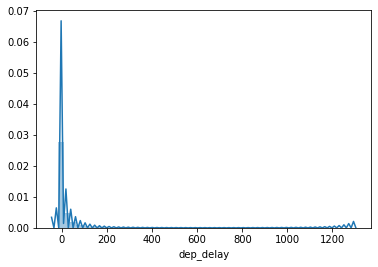

In [74]:
import seaborn as sns
# Re-import the flights data because we modified it.
flights = pd.read_csv('../data/flights.csv')
sns.distplot(flights['dep_delay'].dropna());

How did our predictions do in predicting it?

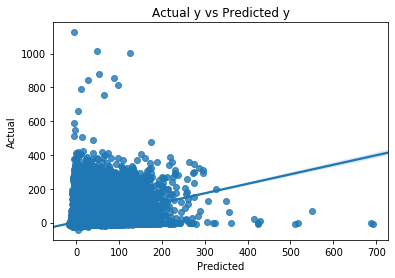

In [82]:
import matplotlib.pyplot as plt

# What does our model think y should be on the
# test data?
ypredicted = forest.predict(Xtest)
yactual = ytest

sns.regplot(x=ypredicted, y=yactual)
plt.title('Actual y vs Predicted y')
plt.xlabel('Predicted')
plt.ylabel('Actual');

So even visually, we can see that our model isn't really making useful predictions.

What could we do better? Probably mostly **feature engineering**.

For example, maybe time of year matters a lot? We have "month" stored as a continuous numeric variable, but maybe we should create a new categorical feature "season" based on what time of year it is. Keeping month as numeric is problematic because December and January are adjacent months but appear to be at opposite ends of the spectrum.
